# CVLFeat Experiments

CVLFeat was simply installed using the conda command:

```conda install -c menpo cyvlfeat```

This version is a revisited code that has the following features
- ability to separate the training set and test set
- full use of the database to store and retrieve FVs

In [80]:
import scipy.ndimage
import matplotlib.colors
import numpy as np
from cyvlfeat.sift import sift
from cyvlfeat.sift import dsift

from PIL import Image
import numpy as np

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

# Code to create a Grayscale image
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


In [81]:
import os

# test some os.path features
print (os.path.basename("file.jpg"))
print ("file.jpg".split('.')[0])


file.jpg
file


In [82]:
import numpy as np

# test normalization on a vector
fv = np.array([0,-2,7])
fv = np.sign(fv) * np.abs(fv) ** 0.5
print (fv)

norm_fv = np.sqrt(np.sum(fv ** 2, 0))
fv /= norm_fv
print (fv)




[ 0.         -1.41421356  2.64575131]
[ 0.         -0.47140452  0.8819171 ]


### Added DB feature

In [83]:
# We use SQLite because there is 0 configuration
import sqlite3
import os
from enum import Enum

# Enum of the various feature types
class FeatureType(Enum):
    HISTOGRAM = 1
    SIFT = 2
    FISHER_V = 3
    NEURAL_NETS = 4

# Database creation
# 
def createDatabase(name, folder, forceCreate):
    """
    This method will create the database with the specified name in the specified folder.
    If a database already exists at the location, it will simply return its path, unless
    forceCreate is set to **True** in which case it will delete the features table.
    """
    path = os.path.join(folder, name)
    print("Checking Database at path: {}".format(path))

    deleteTable = False
    if os.path.exists(path):
        if forceCreate == True:
            deleteTable = True
            print("Database exists: reset the table")
        else:
            return path
        
    # Create the table
    conn = sqlite3.connect(path)
    cur = conn.cursor()
    if deleteTable == True:
        cur.execute('DROP TABLE features')
        conn.commit()

    cur.execute('CREATE TABLE IF NOT EXISTS features (image_id INTEGER PRIMARY KEY, path TEXT NOT NULL, feature_type INTEGER NOT NULL, features BLOB)')
    conn.commit()

    cur.execute('CREATE INDEX IF NOT EXISTS path_type_index ON features (path)')
    conn.commit()

    cur.execute('CREATE INDEX IF NOT EXISTS features_type_index ON features (feature_type)')
    conn.commit()


    conn.close()
    print("Database {} ready in folder: {}".format(name, folder))
    
    return path



### Parameters of the Experiment


In [84]:
# DATABASE
DATABASE_FOLDER = '/Volumes/CYME_SSD/DATABASES'


#DATABASE_NAME = 'inria_holidays_640_mixed001.db'
DATABASE_NAME = 'inria_holidays_640_original_with_path_peak=10.db'
#DATABASE_NAME = 'iceland_640_original_with_path.db'
#DATABASE_NAME = 'INRIA_O_O_ar_rsift.db'

# DATABASE_FOLDER = '/Users/chaitanyaviriyala/Desktop/Inria/Databases/'
# DATABASE_NAME = 'inria_holidays_640_cropped_with_ar_with_path.db'
# if you want to reuse an existing database, set to False
RECREATE_DATABASE = False

# DATASETS
# Several training sets are authorized: those are used for the GMM training
# They can be different from  the dataset
#TRAINING_SETS = ['/Volumes/CYME Libraries/CYME ML DataSets/AUGMENTED_DATASETS/inria_holidays_640_cropped_with_ar']


#TRAINING_SETS = ['/Volumes/CYME_SSD/NewAugmentationswithR/INRIA_640_MK_mixed']
TRAINING_SETS = ['/Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar']
#TRAINING_SETS = ['/Volumes/CYME_SSD/NewAugmentationswithR/oxbuild_images_640']
#TRAINING_SETS = ['/Users/chaitanyaviriyala/Downloads/icelande_640_with_ar']

# The maximum number of training images
TRAINING_LIMIT = 100000

# This is the testing dataset for which the FV will be computed from the GMM 
# that was learned on the training set
#TEST_SET = '/Volumes/CYME Libraries/CYME ML DataSets/AUGMENTED_DATASETS/inria_holidays_640_cropped_with_ar'
TEST_SET = '/Volumes/CYME_SSD/NewAugmentationswithR/INRIA_640_MK_mixed'
#TEST_SET = '/Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar'

# GMM
# The number of gaussians
GMM_K = 128
GMM_K_MULTIPLIER = 10000

# K_MEANS
KNN_K = 50




### Compute a DIGEST for the training set
In order to differentiate the FVs computed using different GMM, we create a digest for the training sets

In [85]:
# COMPUTE A HASH FOR THE TRAINING
digest_str = "|".join(TRAINING_SETS)

import hashlib

TRAINING_DIGEST = hashlib.md5(digest_str.encode()).hexdigest()
print ("Training Digest: {}".format(TRAINING_DIGEST))

Training Digest: 948423b59f49b2ecb18e77f455476ac3


### Feature extraction

In [86]:
import os
import numpy as np
import sqlite3
import pickle
from tqdm import tqdm

# create the database, or reuse if existing and flag is set
dbPath = createDatabase(folder=DATABASE_FOLDER, 
                        name=DATABASE_NAME, 
                        forceCreate=RECREATE_DATABASE)

# open our database
conn = sqlite3.connect(dbPath)
cur = conn.cursor()

## build the list of all the paths and filter them out correctly
training_paths = {}
for training_dir in TRAINING_SETS:
    dir_name = os.path.basename(training_dir)
    dir_content = os.listdir(training_dir)
    training_img_names = [filename
               for filename in dir_content
               if filename.endswith('.jpg')]
    
    print (dir_name)
    training_paths[dir_name] = training_img_names
    
print("Processed {} training sets".format(len(TRAINING_SETS)))
print("Training size: {}".format(len(training_paths)))


image_descs = [] # all descriptors computed
image_paths = [] # full path of the images
iimage = 0


for training_dir in TRAINING_SETS:
    iimage = 0

    dir_name = os.path.basename(training_dir)
    training_img_names = training_paths[dir_name]

    print("Computing SIFT for {}".format(dir_name))

    for filename in tqdm(training_img_names[:TRAINING_LIMIT]):
        if iimage < TRAINING_LIMIT:
            # the full path: to access the file on disk but also insert into the database
            image_path = os.path.join(training_dir,filename)
            cur.execute('SELECT * FROM features WHERE path=? AND feature_type=?', (image_path, FeatureType.SIFT.value))
            row = cur.fetchone()
            if row:
                features_pickle = row[3]
                descriptors = pickle.loads(features_pickle)
                # print(row[1])
            else:       
                image = load_image(image_path)
                gray = rgb2gray(image)
                keypoints, descriptors = sift(gray,compute_descriptor=True,peak_thresh=20)
                features_pickle = pickle.dumps(descriptors)
                cur.execute('INSERT INTO features (path,feature_type,features) values (?,?,?)', 
                    (image_path, FeatureType.SIFT.value, features_pickle))
            # print ("Image {} has descriptors of size: {}".format(iimage,descriptors.shape))
            image_descs.append(descriptors)
            image_paths.append(image_path)

        iimage = iimage + 1
    
    # partial commit
    conn.commit()
    
# close DB connection
conn.close()

print(len(image_descs))

  0%|          | 0/1492 [00:00<?, ?it/s]

Checking Database at path: /Volumes/CYME_SSD/DATABASES/inria_holidays_640_original_with_path_peak=10.db
INRIA_original_with_ar
Processed 1 training sets
Training size: 1
Computing SIFT for INRIA_original_with_ar


100%|██████████| 1492/1492 [00:06<00:00, 229.52it/s]

1492


### Verifying the number of images

In [87]:
print(len(image_descs))
print(len(image_descs[19]))

1492
84


In [88]:
import numpy as np

def rootsift(descs):
    descs = descs.astype(np.float32)
    eps=1e-7
    descs /= (descs.sum(axis=1, keepdims=True) + eps)
    descs1 = np.sqrt(descs)
    return descs1

#image_descs_rsift_1 = list(map(rootsift, image_descs))

image_descs_rsift = [rootsift(descs) for descs in image_descs]

print(len(image_descs_rsift))
print(len(image_descs_rsift[19]))    

1492
84


In [47]:
image_descs_rsift_1 = list(map(rootsift, image_descs))
print(len(image_descs_rsift_1))
print(len(image_descs_rsift_1[19]))

1492
3


### Sampling of the SIFT descriptors, PCA

In [89]:
#Create an option 

option = image_descs
#option_rsift = image_descs_rsift

In [90]:
# make a big matrix with all image descriptors
n_sample = GMM_K * GMM_K_MULTIPLIER

# Modify image_descs_rsift in line number 5
all_desc = np.vstack(option)
print ("all_desc of size: {}".format(all_desc.shape))

# choose n_sample descriptors at random
sample_indices = np.random.choice(all_desc.shape[0], n_sample)
print(len(sample_indices))
sample = all_desc[sample_indices]
print(len(sample))

# until now sample was in uint8. Convert to float32
sample = sample.astype('float32')

# compute mean and covariance matrix for the PCA
mean = sample.mean(axis = 0)
print(len(mean))
sample = sample - mean
print(sample.shape)
cov = np.dot(sample.T, sample)

# compute PCA matrix and keep only 64 dimensions
eigvals, eigvecs = np.linalg.eig(cov)
perm = eigvals.argsort()                   # sort by increasing eigenvalue
pca_transform = eigvecs[:, perm[64:128]]   # eigenvectors for the 64 last eigenvalues

# transform sample with PCA (note that numpy imposes line-vectors,
# so we right-multiply the vectors)
sample = np.dot(sample, pca_transform)

print ("Build a sample of size: {}".format(sample.shape))



all_desc of size: (199394, 128)
1280000
1280000
128
(1280000, 128)
Build a sample of size: (1280000, 64)


### GMM

In [91]:
# Gaussian mixture models
from cyvlfeat.gmm import gmm

# train GMM
print ("Build a GMM for {} clusters".format(GMM_K))


means,covars,priors,ll,posteriors = gmm(sample,n_clusters=GMM_K)
print ("means of shape: {}".format(means.shape))

print ("covars of shape: {}".format(covars.shape))

print ("priors of shape: {}".format(priors.shape))

print ("posteriors of shape: {}".format(posteriors.shape))

print ("Log likelyhood: {}".format(ll))





Build a GMM for 128 clusters
means of shape: (128, 64)
covars of shape: (128, 64)
priors of shape: (128,)
posteriors of shape: (1280000, 128)
Log likelyhood: -395778304.0


### Constructing the Fischer Vectors
We turn the SIFT descriptors into a single Fisher Vector for each image in the training set.
The dimension of such vector is : 2kD where k = number of centroids and D is the dimension
of our decriptors

In [92]:
# Fisher vectors
from cyvlfeat.fisher import fisher

# open our database
conn = sqlite3.connect(dbPath)
cur = conn.cursor()

tmeans = means.transpose()
tcovars = covars.transpose()


print(tmeans.shape)
print(tcovars.shape)
print(priors.shape)
print(len(image_descs))

iimage = 0
#image_fvs = []
for image_desc, image_path in zip(image_descs, image_paths):
    # apply the PCA to the image descriptor (i.e the collection of SIFTS)
    image_desc = np.dot(image_desc - mean, pca_transform)

    # compute the Fisher vector, using only the derivative w.r.t mu
    fv = fisher(image_desc.transpose(),tmeans,tcovars,priors)
    print ("Built a FV of shape {} from image_desc: {} and path: {}".format(fv.shape,image_desc.shape,image_path))

    fv = np.sign(fv) * np.abs(fv) ** 0.5

    norm_fv = np.sqrt(np.sum(fv ** 2, 0))
    fv /= norm_fv

    # image_fvs.append(fv)

    # save the FV in the database
    #print (len(fv.tolist()))
    #print (type(fv.tolist()))

    fv_pickle = pickle.dumps(fv.tolist())
    cur.execute('INSERT INTO features (path,feature_type,features) values (?,?,?)', 
                (image_path, FeatureType.FISHER_V.value, fv_pickle))

    iimage += 1
    if (iimage%50 == 0):
        conn.commit()
        iimage = 0


# commit and close
conn.commit()
conn.close()


(64, 128)
(64, 128)
(128,)
1492
Built a FV of shape (16384,) from image_desc: (12, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/126803.jpg
Built a FV of shape (16384,) from image_desc: (70, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/105002.jpg
Built a FV of shape (16384,) from image_desc: (32, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/101502.jpg
Built a FV of shape (16384,) from image_desc: (214, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/103301.jpg
Built a FV of shape (16384,) from image_desc: (39, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/107601.jpg
Built a FV of shape (16384,) from image_desc: (282, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/144704.jpg
Built a FV of shape (16384,) from image_desc: (411, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/135102.jpg
Built a FV of shape (16384,) from image_desc: (50, 64) 

/Users/chaitanyaviriyala/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


Built a FV of shape (16384,) from image_desc: (315, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/123204.jpg
Built a FV of shape (16384,) from image_desc: (0, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/131600.jpg
Built a FV of shape (16384,) from image_desc: (147, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/135300.jpg
Built a FV of shape (16384,) from image_desc: (84, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/137503.jpg
Built a FV of shape (16384,) from image_desc: (191, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/110802.jpg
Built a FV of shape (16384,) from image_desc: (49, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/133003.jpg
Built a FV of shape (16384,) from image_desc: (77, 64) and path: /Volumes/CYME_SSD/Aspect_Ratio/INRIA_original_with_ar/145803.jpg
Built a FV of shape (16384,) from image_desc: (94, 64) and path: /Volumes/CYME_SSD/Aspec

### Build the set of FVs we want to use for the experiment

In [93]:
def computeFV(path, cur):

    cur.execute('SELECT * FROM features WHERE path=? AND feature_type=?', (path, FeatureType.FISHER_V.value))
    row = cur.fetchone()
    if row:
        features_pickle = row[3]
        fv = pickle.loads(features_pickle)
        # print ("Retrieve a FV for path: {}".format(path))

        return fv
    else:       
        # compute for this image
        image = load_image(path)
        gray = rgb2gray(image)
        keypoints, image_desc = sift(gray,compute_descriptor=True)
        
        #Modified vectors using RootSIFT, if don't want comment out these four lines till 21
        image_desc = image_desc.astype(np.float32)
        eps=1e-7
        image_desc /= (image_desc.sum(axis=1, keepdims=True) + eps)
        image_desc = np.sqrt(image_desc)

        # apply the PCA to the image descriptor (i.e the collection of SIFTS)
        image_desc = np.dot(image_desc - mean, pca_transform)

        # compute the Fisher vector, using only the derivative w.r.t mu
        fv = fisher(image_desc.transpose(),tmeans,tcovars,priors)
        #print ("Built a FV ") #of shape {} from image_desc: {} and path: {}".format(fv.shape,image_desc.shape,image_path))

        fv = np.sign(fv) * np.abs(fv) ** 0.5

        norm_fv = np.sqrt(np.sum(fv ** 2, 0))
        fv /= norm_fv

        fv_pickle = pickle.dumps(fv.tolist())
        cur.execute('INSERT INTO features (path,feature_type,features) values (?,?,?)', 
               (image_path, FeatureType.FISHER_V.value, fv_pickle))

        
        return fv

   
# open our database
conn = sqlite3.connect(dbPath)
cursor = conn.cursor()
    
dir_content = os.listdir(TEST_SET)

# build the list of full paths
testing_image_names = [filename
               for filename in dir_content
               if filename.endswith('.jpg')]

testing_paths = [os.path.join(TEST_SET,filename)
               for filename in testing_image_names]


fvs = []

for testing_path in tqdm(testing_paths[:])  :
    # compute the Fisher Vector if not already present in the database
    fv =computeFV(testing_path, cursor)
    fvs.append(fv)

fvs_testing = np.asarray(fvs)

# we are done with the database
conn.commit()

conn.close()

print(fvs_testing.shape)


100%|██████████| 16412/16412 [48:57<00:00,  5.59it/s] 


(16412, 16384)


In [94]:
# fit the neighbours, continue this if you dont want to use the next step
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=KNN_K).fit(fvs_testing)    


### Dimensionality Reduction using Autoencoder and Decoder for improved clustering

In [ ]:
import os
import numpy as np # linear algebra
from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

In [ ]:
# Scaling Train and Test data for Neural Net
train = fvs_testing
print(test.shape)

train_scaled = minmax_scale(train, axis = 0)
test_scaled = minmax_scale(test, axis = 0)


# Training a Auto Encoder
model.fit(X_train, X_train)

In [ ]:
input_dim = Input(shape = (ncol, ))

# Encoder Layers
encoded1 = Dense(3000, activation = 'relu')(input_dim)
encoded2 = Dense(2750, activation = 'relu')(encoded1)
encoded3 = Dense(2500, activation = 'relu')(encoded2)
encoded4 = Dense(2250, activation = 'relu')(encoded3)
encoded5 = Dense(2000, activation = 'relu')(encoded4)
encoded6 = Dense(1750, activation = 'relu')(encoded5)
encoded7 = Dense(1500, activation = 'relu')(encoded6)
encoded8 = Dense(1250, activation = 'relu')(encoded7)
encoded9 = Dense(1000, activation = 'relu')(encoded8)
encoded10 = Dense(750, activation = 'relu')(encoded9)
encoded11 = Dense(500, activation = 'relu')(encoded10)
encoded12 = Dense(250, activation = 'relu')(encoded11)
encoded13 = Dense(encoding_dim, activation = 'relu')(encoded12)

# Decoder Layers
decoded1 = Dense(250, activation = 'relu')(encoded13)
decoded2 = Dense(500, activation = 'relu')(decoded1)
decoded3 = Dense(750, activation = 'relu')(decoded2)
decoded4 = Dense(1000, activation = 'relu')(decoded3)
decoded5 = Dense(1250, activation = 'relu')(decoded4)
decoded6 = Dense(1500, activation = 'relu')(decoded5)
decoded7 = Dense(1750, activation = 'relu')(decoded6)
decoded8 = Dense(2000, activation = 'relu')(decoded7)
decoded9 = Dense(2250, activation = 'relu')(decoded8)
decoded10 = Dense(2500, activation = 'relu')(decoded9)
decoded11 = Dense(2750, activation = 'relu')(decoded10)
decoded12 = Dense(3000, activation = 'relu')(decoded11)
decoded13 = Dense(ncol, activation = 'sigmoid')(decoded12)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded13)

# Compile the Model
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')

In [ ]:
autoencoder.summary()

In [ ]:
autoencoder.fit(X_train, X_train, nb_epoch = 10, batch_size = 32, shuffle = False, validation_data = (X_test, X_test))

In [ ]:
# Use Encoder level to reduce dimension of train and test data
encoder = Model(inputs = input_dim, outputs = encoded13)
encoded_input = Input(shape = (encoding_dim, ))

encoded_train = encoder.predict(train_scaled)
print(encoded_train.shape)


In [ ]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=KNN_K).fit(encoded_train) 

### Get those query images ending with 00

In [95]:
# get the indices of the query images (the subset of images that end in "00")
query_image_num = [i for i, name in enumerate(testing_image_names) if name.split('.')[0][-2:] == "00"]

query_image_num_r5 = [i for i, name in enumerate(testing_image_names) if name.split('.')[0][-5:] == "00_r5"]

query_image_name = [name for i, name in enumerate(testing_image_names) if name.split('.')[0][-2:] == "00"]

query_image_name_r5 = [name for i, name in enumerate(testing_image_names) if name.split('.')[0][-5:] == "00_r5"]

# corresponding descriptors

# query_fvs = fvs_testing[query_image_num]

query_fvs = encoded_train[query_image_num]


print(len(query_image_num))
print(query_fvs.shape)

500
(500, 16384)


### Compute the K Nearest Neighbours for our testing set

In [96]:
 distances, results = nbrs.kneighbors(X=query_fvs,n_neighbors=KNN_K)
print((results[:2]))
#print(distances)

[[   11   180 15357 15358 11609 15359 16186  1484 11608  9645 12106 15420
    254   245 12105  9643 15361 16185   327 15418 15419 15421 15364  1955
  15360 15747  9644 14060 15363 16175 16174 12103 15430 16176    28 12569
  13373 12575 11393 14819 15830 11612   359 14058  9642  1465   585 11110
    724  2136]
 [   12 15670 15671 12148 14611 13246 12147 13245   693 15669 15667 12154
  12162   594 14333 15770 15771 13892 12156 12164 14610 12970 14717 10016
   1223 15159 14332 12500  1266 14005 15769 15643 13100 12166 14335 13244
  15768   272 12155   840  3586 13098 15668  6506 13036 13762 14687 10223
  14719 14592]]


In [97]:
print(type(results))

<class 'numpy.ndarray'>


### compute_ap OXFORD

In [98]:
import sys

from typing import List

def compute_ap(pos: List[str], ranked_list: List[str]):
    """Compute average precision against a retrieved list of images. There are some bits that
    could be improved in this, but is a line-to-line port of the original C++ benchmark code.
    Args:
        pos (List[str]): List of positive samples. This is normally a conjugation of
        the good and ok samples in the ground truth data.
        amb (List[str]): List of junk samples. This is normally the junk samples in
        the ground truth data. Omitting this makes no difference in the AP.
        ranked_list (List[str]): List of retrieved images from query to be evaluated.
    Returns:
        float: Average precision against ground truth - range from 0.0 (worst) to 1.0 (best).
    """

    intersect_size, old_recall, ap = 0.0, 0.0, 0.0
    old_precision, j = 1.0, 1.0

    for e in ranked_list:

        if e in pos:
            intersect_size += 1.0

        recall = intersect_size / len(pos)
        precision = intersect_size / j
        ap += (recall - old_recall) * ((old_precision + precision) / 2.0)

        old_recall = recall
        old_precision = precision
        j += 1.0

    return ap




### AP et mAP using Oxford calculation method

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

aps1 = []
aps2 = []
aps3 = []
query_name_list = []
index = 0
out = open('CVL_INRIA_ar_128_00_TD4_peak=10.csv', 'w')
title = "qName, AP1_CVL, AP2_CVL, AP3_C VL\n"
out.write(title)

#df = pd.DataFrame([,,,], columns = ["QueryName","AP1", "AP2","AP3"])

for qimno, qres in zip(query_image_num, results):
    qname = testing_image_names[qimno]
    query_name_list.append(qname)
    qname_no_extension = qname.split('.')[0]

    
    # cluster size 
    # elements of the cluster have the same first 4 char but are no variants
    cluster = set([name for i, name in enumerate(testing_image_names)
                            if name[:4] == qname[:4] and '_' not in name])
    # collect the positive results in the dataset
    
    # AP1: the positives are the images that are a variation of the original
    # i.e the positives have the same prefix as the query image
    
    positive_results_1 = set([name for name in testing_image_names
                            if name[:6] == qname[:6]])

    pos_res_1 = list(positive_results_1)
    print (pos_res_1)



    # AP2: the positives are the images that are a variation of the original or variations of the images in the cluster
    # i.e the positives have the same prefix as the query image

    positive_results_2 = set([name for i, name in enumerate(testing_image_names)
                            if name[:4] == qname[:4]])
    pos_res_2 = list(positive_results_2)
    pos_res_3 = pos_res_2
    
    #print (pos_res_2)

 
    # these are the sizes to use to restrict our positive sets
    variants_count = len(positive_results_1)
    variants_and_similar_counts = len(positive_results_2)


    # ranks of positives. 
    # we do include the query ... that's just a computation choice
    
    
    ranks_1 = map(lambda i: testing_image_names[i], qres[0:variants_count])
    ranks_1_list = list(ranks_1)
    print(ranks_1_list)
    
    ranks_2 = map(lambda i: testing_image_names[i], qres[0:variants_and_similar_counts])
    ranks_2_list = list(ranks_2)
    
    
    #print('Len(POS_RES_1)',len(pos_res_1))
    #print('Len(Ranks_1)',len(ranks_1_list))
#     print('Len(POS_RES_2)',len(pos_res_2))
#     print('Len(Ranks_2)',len(ranks_2_list))
    
    
    
    ranks_3 = map(lambda i: testing_image_names[i], qres)
    ranks_3_list = list(ranks_3)

    if len(pos_res_1) > 0:
        ap1 = compute_ap(pos_res_1,ranks_1_list)
    ap2 = compute_ap(pos_res_2,ranks_2_list)
    ap3 = compute_ap(pos_res_3,ranks_3_list)
   

    
    
    out.write("%s,%.3f,%.3f,%.3f\n" % (qname, ap1, ap2, ap3))
    # print("query %s, cluster_size = %d, variants_count = %d, variants_and_similar_counts = %d" % (qname, len(cluster), variants_count, variants_and_similar_counts))
    # print (sorted(cluster))
    # print (sorted(pos_res_1))
    # print (sorted(pos_res_2))
    print("query %s, AP1 = %.3f, AP2 = %.3f, AP3 = %.3f" % (qname, ap1, ap2, ap3))
    
    #df = pd.DataFrame([query_name_list,ap1,ap2,ap3], columns = ["QueryName","AP1", "AP2","AP3"])
    
    aps1.append(ap1)
    aps2.append(ap2)
    aps3.append(ap3)
    
#     plt.plot([qname],[ap], 'ro')
#     plt.xlabel('Query_Image_Number')
#     plt.ylabel('AVERAGE PRESICION')
#     plt.title('AP VS Qyery')
    

out.close()
length = len(query_image_num)
print("mean AP1 of %s query_imnos is = %.3f" % (length, np.mean(aps1)))
print("mean AP2 of %s query_imnos is = %.3f" % (length, np.mean(aps2)))
print("mean AP3 of %s query_imnos is = %.3f" % (length, np.mean(aps3)))

['101700_c2.jpg', '101700.jpg', '101700_r5.jpg', '101700_c5.jpg', '101700_r2.jpg', '101700_r4.jpg', '101700_r3.jpg', '101700_c3.jpg', '101700_r1.jpg', '101700_c4.jpg', '101700_c1.jpg']
['101700.jpg', '107401.jpg', '107401_r5.jpg', '107401_r4.jpg', '134802_r3.jpg', '107401_r3.jpg', '101700_r1.jpg', '131802.jpg', '134802_r4.jpg', '145402_r2.jpg', '131802_r1.jpg']
query 101700.jpg, AP1 = 0.111, AP2 = 0.050, AP3 = 0.054
['105200_c2.jpg', '105200_r5.jpg', '105200_r2.jpg', '105200_r1.jpg', '105200_c3.jpg', '105200_c5.jpg', '105200.jpg', '105200_c4.jpg', '105200_c1.jpg', '105200_r3.jpg', '105200_r4.jpg']
['105200.jpg', '105200_r2.jpg', '105200_r1.jpg', '131503_r4.jpg', '113400_r1.jpg', '123301_r1.jpg', '131503_r5.jpg', '123301_r2.jpg', '118800.jpg', '105200_r3.jpg', '105200_r5.jpg']
query 105200.jpg, AP1 = 0.345, AP2 = 0.172, AP3 = 0.178
['148300_c4.jpg', '148300_c5.jpg', '148300_r4.jpg', '148300_c3.jpg', '148300_r2.jpg', '148300_c2.jpg', '148300_r5.jpg', '148300.jpg', '148300_c1.jpg', '14830

In [20]:
print(len(query_name_list))
print(len(aps1))
print(len(aps2))
print(len(aps3))

query_imnos = []
for i, path in enumerate(image_paths):
    if os.path.basename(path) in query_name_list:
        query_imnos.append(i)
print(len(query_imnos))


df1 = pd.DataFrame(list(zip(query_name_list,query_imnos, aps1, aps2, aps3)), 
               columns =["QueryName","Query_Imnos","AP1", "AP2","AP3"]) 
df1.head(3)
df1.shape

df2 = df1.sort_values(['AP1'], ascending=[True])
print(df2.head(5))
query_image_name1 = df2['QueryName'].tolist()
print(query_image_name1[:5])


df3 = df1.sort_values(['AP2'], ascending=[True])
print(df3.head(3))
query_image_name2 = df3['QueryName'].tolist()
print(query_image_name2[:5])



df4 = df1.sort_values(['AP3'], ascending=[True])
print(df4.head(3))
query_image_name3 = df4['QueryName'].tolist()
print(query_image_name3[:5])

500
500
500
500
0
Empty DataFrame
Columns: [QueryName, Query_Imnos, AP1, AP2, AP3]
Index: []
[]
Empty DataFrame
Columns: [QueryName, Query_Imnos, AP1, AP2, AP3]
Index: []
[]
Empty DataFrame
Columns: [QueryName, Query_Imnos, AP1, AP2, AP3]
Index: []
[]


### Display

In [50]:
from sklearn.neighbors import NearestNeighbors
    
nbrs = NearestNeighbors(n_neighbors=12).fit(fvs_testing)
 
# some standard queries 

a1 = '128600.jpg'
a2 = '144800.jpg'
a3 = '148200.jpg'
a4 = '134500.jpg'
a5 = '116200.jpg'
a6 = '129800.jpg'




# get the indices of the query images (the subset of images that end in "00")
# query_names = set([a1,a2,
#                    a3, a4,
#                    a5,a6])

query_names = query_image_name2[:5]


# query_imnos = []
# for i, path in enumerate(image_paths):
#     if os.path.basename(path) in query_names:
#         query_imnos.append(i)
# print (query_imnos)

# df2 = df1.sort_values(['AP1'], ascending=[True])
# print(df2.head(5))
# query_imnos_5 = df2['Query_Imnos'].tolist()
# print(query_imnos_5[:5])
# query_imnos = query_imnos_5[:5]


df3 = df1.sort_values(['AP2'], ascending=[True])
print(df3.head(3))
query_imnos_5 = df3['Query_Imnos'].tolist()
print(query_image_name2[:5])
query_imnos = query_imnos_5[:5]


# df4 = df1.sort_values(['AP3'], ascending=[True])
# print(df4.head(3))
# query_imnos_5 = df4['Query_Imnos'].tolist()
# print(query_image_name3[:5])
# query_imnos = query_imnos_5[:5]




# print(df1.head(3))
# query_imnos_5 = df1['Query_Imnos'].tolist()
# print(query_image_name3[:5])
# query_imnos = query_imnos_5[:5]



# corresponding descriptors
query_fvs = fvs_testing[query_imnos]
print(query_fvs.shape)

# get the 8 NNs for all query images in the image_fvs array
distances, results = nbrs.kneighbors(X=query_fvs,n_neighbors=15)

print (results.shape)
#print (distances)
print(distances.shape)

         QueryName  Query_Imnos  AP1       AP2       AP3
129  137000_r5.jpg        11162  1.0  0.144431  0.144431
109  139000_r5.jpg        10627  1.0  0.182945  0.182945
114  138500_r5.jpg        10792  1.0  0.193015  0.193015
['137000_r5.jpg', '139000_r5.jpg', '138500_r5.jpg', '113400_r5.jpg', '134800_r5.jpg']
(5, 16384)
(5, 15)
(5, 15)


In [51]:
# df2 = df1.sort_values(['AP1'], ascending=[True])
# #print(df2.head(5))
# query_imnos_5 = df2['Query_Imnos'].tolist()
# #print(query_imnos_5[:5])
# query_imnos = query_imnos_5[:5]
# df2_imnos = df2
# df2_imnos.drop('QueryName', axis=1, inplace=True)
# print(df2_imnos.head(5))


df3 = df1.sort_values(['AP2'], ascending=[True])
#print(df3.head(5))
query_imnos_5 = df3['Query_Imnos'].tolist()
print(query_imnos_5[:5])
query_imnos = query_imnos_5[:5]
df3_imnos = df3
df3_imnos.drop('QueryName', axis=1, inplace=True)
print(df3_imnos.head(5))


# df4 = df1.sort_values(['AP3'], ascending=[True])
# #print(df4.head(5))
# query_imnos_5 = df4['Query_Imnos'].tolist()
# print(query_imnos_5[:5])
# query_imnos = query_imnos_5[:5]
# df4_imnos = df4
# df4_imnos.drop('QueryName', axis=1, inplace=True)
# print(df4_imnos.head(5))


[11162, 10627, 10792, 14607, 11617]
     Query_Imnos  AP1       AP2       AP3
129        11162  1.0  0.144431  0.144431
109        10627  1.0  0.182945  0.182945
114        10792  1.0  0.193015  0.193015
365        14607  1.0  0.200000  0.200000
151        11617  1.0  0.205161  0.205161


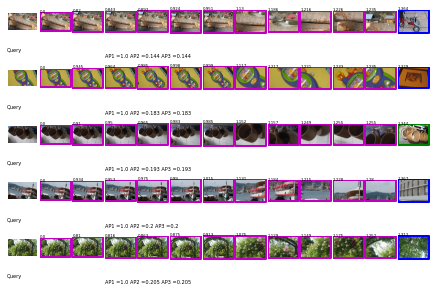

In [52]:
from matplotlib import pyplot
from matplotlib.image import imread

nrow = len(query_names)   # number of query images to show
nres = 12  # number of results per query

def show_image(imno, frame_color):
    im = imread(image_paths[imno])
    pyplot.imshow(im)
    h, w = im.shape[:2]
    pyplot.plot([0, 0, w, w, 0], [0, h, h, 0, 0], frame_color, linewidth = 2)
    pyplot.axis('off')

# reduce the margins
pyplot.subplots_adjust(wspace = 0, hspace = 0,
                       top = 0.99, bottom = 0.01, left = 0.01, right = 0.99)

no = 1  # index current of subfigure
index_text_row = 0
for qno in range(nrow):
    #print(qno)
    pyplot.subplot(nrow, nres + 1, no); no += 1
    pyplot.annotate('Query', xy=(0,-20), xycoords= 'axes pixels', fontsize ='5')
    # show query image with white outline
    qimno = query_imnos[qno]
    show_image(qimno, 'w')
    #print (results[qno, :nres])
    index_text_column = 0
    


    m = df3_imnos[df3_imnos['Query_Imnos'] == qimno].iloc[0]
    m1 = m.tolist()
    
    for qres in results[qno, :nres]:
        pyplot.subplot(nrow, nres + 1, no); no += 1
        pyplot.annotate(round(distances[index_text_row,index_text_column],3), xy = (0,0),fontsize ='4')
        if no % (nres+1) == 5 :
            pyplot.annotate('AP1 ='+ str(round(m1[1],3))+' '+'AP2 ='+ str(round(m1[2],3))+' '+'AP3 ='+ str(round(m1[3],3))
                             , xy=(0,-25), xycoords= 'axes pixels', fontsize ='5')
        

        # use image name to determine if it is a TP or FP result
        # we compare the first 4 char of the image name
        queryImName = os.path.basename(image_paths[qimno])

        resImName = os.path.basename(image_paths[qres])
        

        is_ok = queryImName[:4] == resImName[:4]
        is_crop = queryImName[:6] == resImName[:6]
        if is_ok :
            color = 'g'
            if 'c' in resImName :
                color = 'y'
            if is_crop :    
                color = 'm'
        else:
            color = 'b'
            
        show_image(qres, color)
        index_text_column += 1
    index_text_row += 1

        
     
#pyplot.show()


file_name = 'CVLINRIAMIXED_AP2_r5'
output_dir = '/Users/chaitanyaviriyala/cymeimagetoolbox/INRIA/'
figurePath = output_dir + file_name + '.png'
pyplot.xlabel('CVLFeat_Cropped')
#pyplot.title('CVLFeat_Cropped')
pyplot.savefig(figurePath, dpi = 300) 
#pyplot.tight_layout()
pyplot.show()

